# **Lab3 : Image Segmentation (Histogram of Oriented Gradients & K-Mean Clustering)**

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import measure

import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os 
import random

## Load Image

(np.float64(-0.5), np.float64(899.5), np.float64(597.5), np.float64(-0.5))

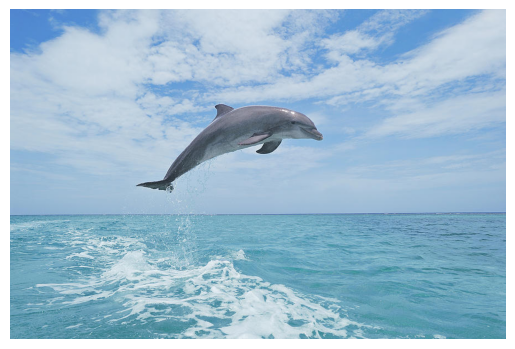

In [2]:
### START CODE HERE ###
image_path = "./asset/img3-1.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
### END CODE HERE ###

## Histogram of Oriented Gradients

Blur the image then apply to the [`hog()`](<https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog:~:text=skimage.feature.hog(,%23>)
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/1.png?raw=true)
</details>

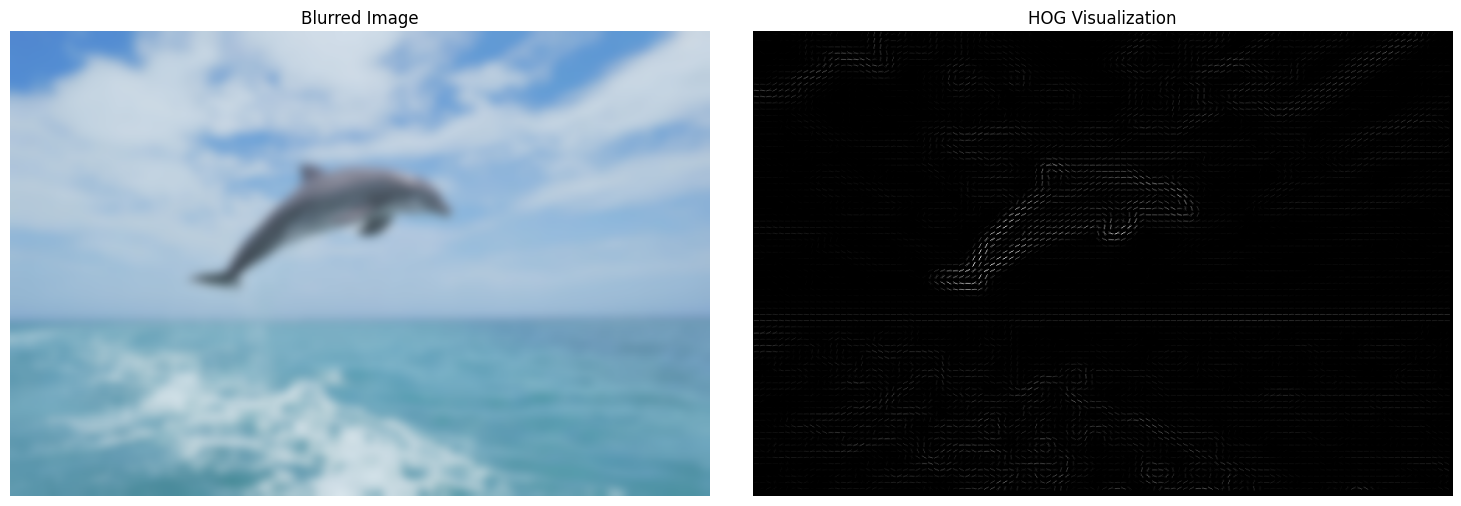

In [3]:
### START CODE HERE ###

# Apply Gaussian blur to reduce noise
blurry_image = cv2.GaussianBlur(image, (41, 41), 0)

# Convert to grayscale for HOG
blurry_gray = cv2.cvtColor(blurry_image, cv2.COLOR_RGB2GRAY)

# Extract HOG features with visualization
fd, hog_image = hog(blurry_gray, 
                    orientations=9, 
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), 
                    visualize=True,
                    transform_sqrt=True)

# Display the results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(blurry_image, cmap='gray')
axes[0].set_title('Blurred Image')
axes[0].axis('off')

axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('HOG Visualization')
axes[1].axis('off')

plt.tight_layout()
plt.show()
### END CODE HERE ###

Complete the `HOGSubimageExtractor()`.

That extracts Histogram of Oriented Gradients features from sub-images of a larger image. It divides the image into overlapping tiles, computes HOG features for each tile, and stores both the feature vectors and visualizations. The class also provides a method to plot the HOG visualizations.

**Attributes:**
- `image`: The input image.
- `tile_size`: The size of each sub-image to extract.
- `stride`: The pixel stride between consecutive sub-images.
- `hGrid`: An array of indices representing the starting positions for rows of sub-images.
- `wGrid`: An array of indices representing the starting positions for columns of sub-images.
- `hog_features`: A list to store the HOG feature vectors for each sub-image.
- `hog_images`: A list to store the visualized HOG images for each sub-image (optional).

**Methods:**
- `extract_hog_features()`: Compute HOG features for each sub-image.
- `plot_hog_images()`: Plots the HOG visualization images.
- `get_num_grid()`: Return the number of rows and columns in the grid of sub-images.


In [16]:
### START CODE HERE ###
class HOGSubimageExtractor:
    def __init__(self, image, tile_size, stride):
        # Convert to grayscale if image is in color
        if len(image.shape) == 3:
            self.image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            self.image = image
            
        self.tile_size = tile_size
        self.stride = stride
        
        # Get image dimensions
        self.h, self.w = self.image.shape[:2]
        
        # Create grid coordinates for sliding window
        self.hGrid = np.arange(0, self.h - tile_size + 1, stride)
        self.wGrid = np.arange(0, self.w - tile_size + 1, stride)
        
        # Initialize feature storage
        self.hog_features = []
        self.hog_images = []
        
        # Extract HOG features from all tiles
        self.extract_hog_features()

    def extract_hog_features(self):
        """Extract HOG features from each sub-image tile"""
        self.hog_features = []
        self.hog_images = []
        
        # Iterate through all grid positions
        for h_start in self.hGrid:
            for w_start in self.wGrid:
                # Extract sub-image tile
                tile = self.image[h_start:h_start + self.tile_size, 
                                w_start:w_start + self.tile_size]
                
                # Compute HOG features for this tile
                fd, hog_img = hog(tile,
                                orientations=9,
                                pixels_per_cell=(6, 6),
                                cells_per_block=(6, 4),
                                visualize=True,
                                transform_sqrt=True)
                
                # Store features and visualization
                self.hog_features.append(fd)
                self.hog_images.append(hog_img)

    def plot_hog_images(self):
        """Plot HOG visualization images in a grid layout"""
        num_h, num_w = self.get_num_grid()
        
        # Create subplot grid
        fig, axes = plt.subplots(num_h, num_w, figsize=(15, 10))
        
        # Handle single row or column cases
        if num_h == 1:
            axes = axes.reshape(1, -1)
        elif num_w == 1:
            axes = axes.reshape(-1, 1)
        
        # Plot each HOG image
        idx = 0
        for i in range(num_h):
            for j in range(num_w):
                if idx < len(self.hog_images):
                    axes[i, j].imshow(self.hog_images[idx], cmap='gray')
                    axes[i, j].axis('off')
                    idx += 1
                else:
                    axes[i, j].axis('off')
                    
        plt.subplots_adjust(hspace=0.1, wspace=0.1)  # Reduce vertical spacing
        plt.tight_layout()
        plt.show()

    def get_num_grid(self):
        """Return the number of rows and columns in the grid"""
        return len(self.hGrid), len(self.wGrid)
### END CODE HERE ###

Let's use `HOGSubimageExtractor()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output from hog_extractor.plot_hog_images()</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/2.png)
</details>

Number of grids: (8, 13)


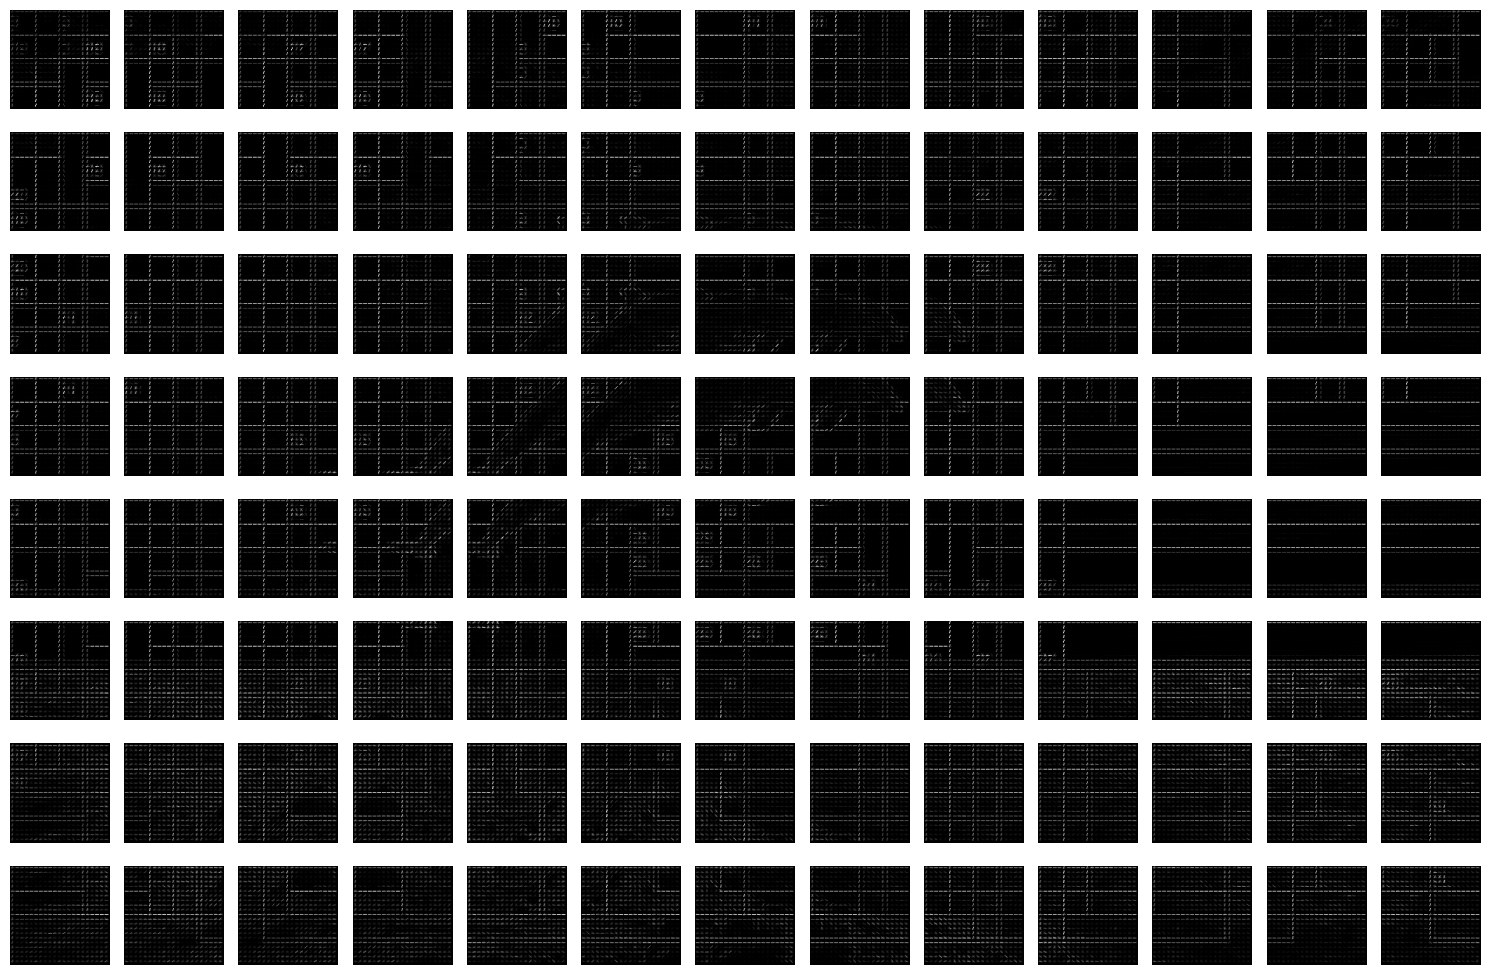

In [17]:
### START CODE HERE ###
tile_size = 128  # Size of each tile (128x128 pixels)
stride = 64  # Stride for sliding window (32 pixels)
hog_extractor = HOGSubimageExtractor(image, tile_size, stride)
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()
### END CODE HERE ###


## K-Mean Clustering
Complete the `KMeansCluster()`.
Perform K-means clustering on Histogram of Oriented Gradients (HOG) features extracted from an image.
**Attriburtes:**
- `hog_extractor`: An object responsible for extractin HOG features from an image.
- `n_clusters`: The number of clusters to use in K-means.
- `cluster_array`: A 2D array representing the cluster assignments for each grid cell.
- `all_labels`: A 2D array representing the connected components (objects) identified after clustering.
- `bounding_boxes`: A list of tuples containing (object_id, start_coordinates, end_coordinates) for each detected object.

**Method:**
- `perform_clustering()`: Performs K-means clustering on the HOG features extracted by the hog_extractor object.<br>
It then reshapes the cluster assignmentss into a grid and identifies connected components using the `measure.label()` function.
- `plot_cluster_and_labels()`: Visualize the cluster assignments and connected components as images using Matplotlib.
- `get_bounding_boxes()`: Extracts bounding boxes for each detected object.

In [18]:
### START CODE HERE ###
class KMeansCluster:
    def __init__(self, hog_extractor, n_clusters=3, random_state=42):
        self.hog_extractor = hog_extractor
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.cluster_array = None
        self.all_labels = None
        self.bounding_boxes = []
        self.perform_clustering()

    def perform_clustering(self):
        """Perform K-means clustering on HOG features"""
        # Initialize K-means with specified parameters
        kmeans = KMeans(n_clusters=self.n_clusters, 
                       random_state=self.random_state, 
                       n_init=10)
        
        # Fit K-means on the HOG features
        cluster_labels = kmeans.fit_predict(self.hog_extractor.hog_features)
        
        # Reshape cluster labels to match the grid layout
        num_h, num_w = self.hog_extractor.get_num_grid()
        self.cluster_array = cluster_labels.reshape(num_h, num_w)
        
        # Find connected components using measure.label
        self.all_labels = measure.label(self.cluster_array, connectivity=2)

    def plot_cluster_and_labels(self):
        """Visualize cluster assignments and connected components"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot K-means clusters
        im1 = axes[0].imshow(self.cluster_array, cmap='tab10', interpolation='nearest')
        axes[0].set_title('K-means Clusters')
        axes[0].axis('off')
        plt.colorbar(im1, ax=axes[0], shrink=0.6)
        
        # Plot connected components (labeled regions)
        im2 = axes[1].imshow(self.all_labels, cmap='tab20', interpolation='nearest')
        axes[1].set_title('Connected Components (Objects)')
        axes[1].axis('off')
        plt.colorbar(im2, ax=axes[1], shrink=0.6)
        
        plt.tight_layout()
        plt.show()

    def get_bounding_boxes(self):
        """Extract bounding boxes for each detected object"""
        self.bounding_boxes = []
        
        # Get unique labels (excluding background label 0)
        unique_labels = np.unique(self.all_labels)
        unique_labels = unique_labels[unique_labels != 0]  # Remove background
        
        for label in unique_labels:
            # Find coordinates where this label appears
            coords = np.where(self.all_labels == label)
            
            if len(coords[0]) > 0:  # Ensure we have coordinates
                # Get bounding box in grid coordinates
                min_row, max_row = np.min(coords[0]), np.max(coords[0])
                min_col, max_col = np.min(coords[1]), np.max(coords[1])
                
                # Convert grid coordinates to image pixel coordinates
                start_h = self.hog_extractor.hGrid[min_row]
                end_h = self.hog_extractor.hGrid[max_row] + self.hog_extractor.tile_size
                start_w = self.hog_extractor.wGrid[min_col]
                end_w = self.hog_extractor.wGrid[max_col] + self.hog_extractor.tile_size
                
                # Ensure coordinates are within image bounds
                end_h = min(end_h, self.hog_extractor.h)
                end_w = min(end_w, self.hog_extractor.w)
                
                # Store bounding box: (object_id, (start_x, start_y), (end_x, end_y))
                self.bounding_boxes.append((label, (start_w, start_h), (end_w, end_h)))
        
        return self.bounding_boxes
### END CODE HERE ###

Complete the function below. Using [`cv2.rectangle()`](<https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html#:~:text=511%2C511)%2C(255%2C0%2C0)%2C5)-,Drawing%20Rectangle,-To%20draw%20a>)

In [7]:
### START CODE HERE ###
def draw_bbox(image,bboxes):
    """Draw bounding boxes on the image"""
    for label, (start_x, start_y), (end_x, end_y) in bboxes:
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (255, 0, 0), 2)
        cv2.putText(image, str(label), (start_x, start_y - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    return image
### END CODE HERE ###


Let's use `KMeansCluster()` and `draw_bbox()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-3.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/3.png?raw=true)

![image-4.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/4.png?raw=true)
</details>

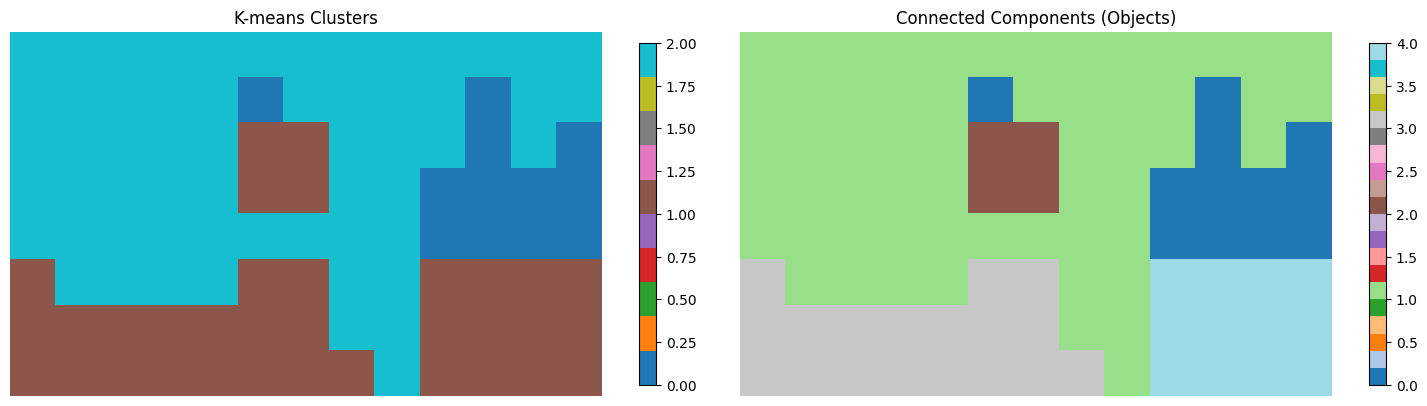

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [198, 212, 225],
        [198, 212, 225]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [198, 212, 225],
        [198, 212, 225]],

       [[255,   0,   0],
        [255,   0,   0],
        [ 80, 134, 208],
        ...,
        [255,   0,   0],
        [198, 212, 225],
        [198, 212, 225]],

       ...,

       [[ 89, 147, 169],
        [ 89, 147, 169],
        [ 92, 150, 172],
        ...,
        [ 82, 153, 173],
        [ 77, 148, 168],
        [ 76, 147, 167]],

       [[ 88, 146, 168],
        [ 89, 147, 169],
        [ 91, 149, 171],
        ...,
        [ 77, 148, 166],
        [ 72, 143, 161],
        [ 69, 140, 158]],

       [[ 93, 151, 173],
        [ 96, 154, 176],
        [100, 158, 180],
        ...,
        [ 78, 149, 167],
        [ 74, 145, 163],
        [ 70, 141, 159]]

In [19]:
kmeans_cluster = KMeansCluster(hog_extractor)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image,bboxes)

---

## Experiment
Do the experiment to identify 3 best parameters that produce the perfectly fitting bounding box of the object of interest in the image.

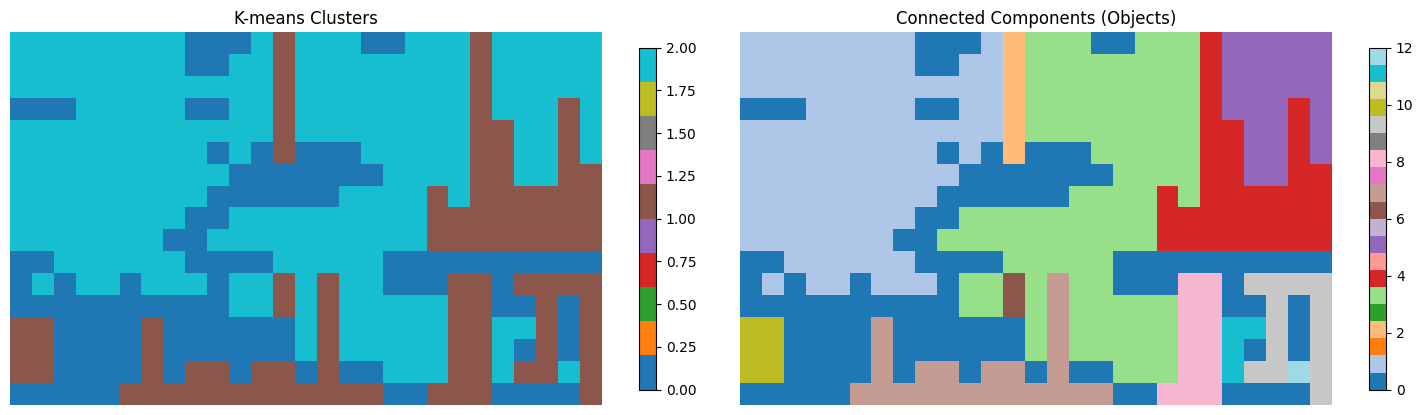

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [198, 212, 225],
        [198, 212, 225]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [198, 212, 225],
        [198, 212, 225]],

       [[255,   0,   0],
        [255,   0,   0],
        [ 80, 134, 208],
        ...,
        [255,   0,   0],
        [198, 212, 225],
        [198, 212, 225]],

       ...,

       [[ 89, 147, 169],
        [ 89, 147, 169],
        [ 92, 150, 172],
        ...,
        [ 82, 153, 173],
        [ 77, 148, 168],
        [ 76, 147, 167]],

       [[ 88, 146, 168],
        [ 89, 147, 169],
        [ 91, 149, 171],
        ...,
        [ 77, 148, 166],
        [ 72, 143, 161],
        [ 69, 140, 158]],

       [[ 93, 151, 173],
        [ 96, 154, 176],
        [100, 158, 180],
        ...,
        [ 78, 149, 167],
        [ 74, 145, 163],
        [ 70, 141, 159]]

In [20]:
### START CODE HERE ###

tile_size = 64
stride = 32
hog_extractor = HOGSubimageExtractor(image, tile_size, stride)
kmeans_cluster = KMeansCluster(hog_extractor)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image,bboxes)


### END CODE HERE ###

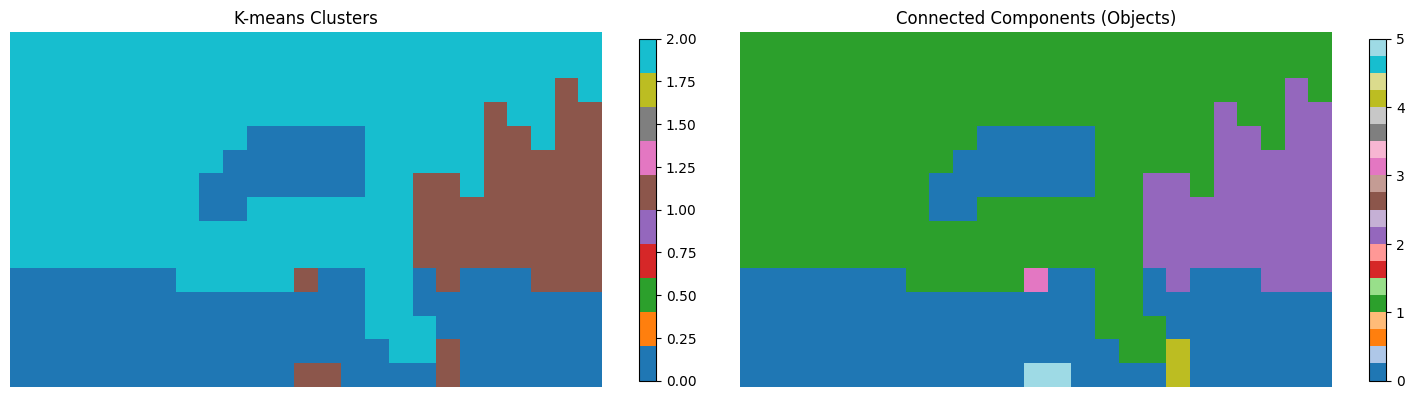

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [198, 212, 225],
        [198, 212, 225]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [198, 212, 225],
        [198, 212, 225]],

       [[255,   0,   0],
        [255,   0,   0],
        [ 80, 134, 208],
        ...,
        [255,   0,   0],
        [198, 212, 225],
        [198, 212, 225]],

       ...,

       [[ 89, 147, 169],
        [ 89, 147, 169],
        [ 92, 150, 172],
        ...,
        [ 82, 153, 173],
        [ 77, 148, 168],
        [ 76, 147, 167]],

       [[ 88, 146, 168],
        [ 89, 147, 169],
        [ 91, 149, 171],
        ...,
        [ 77, 148, 166],
        [ 72, 143, 161],
        [ 69, 140, 158]],

       [[ 93, 151, 173],
        [ 96, 154, 176],
        [100, 158, 180],
        ...,
        [ 78, 149, 167],
        [ 74, 145, 163],
        [ 70, 141, 159]]

In [21]:
### START CODE HERE ###

tile_size = 128
stride = 32
hog_extractor = HOGSubimageExtractor(image, tile_size, stride)
kmeans_cluster = KMeansCluster(hog_extractor)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image,bboxes)



### END CODE HERE ###

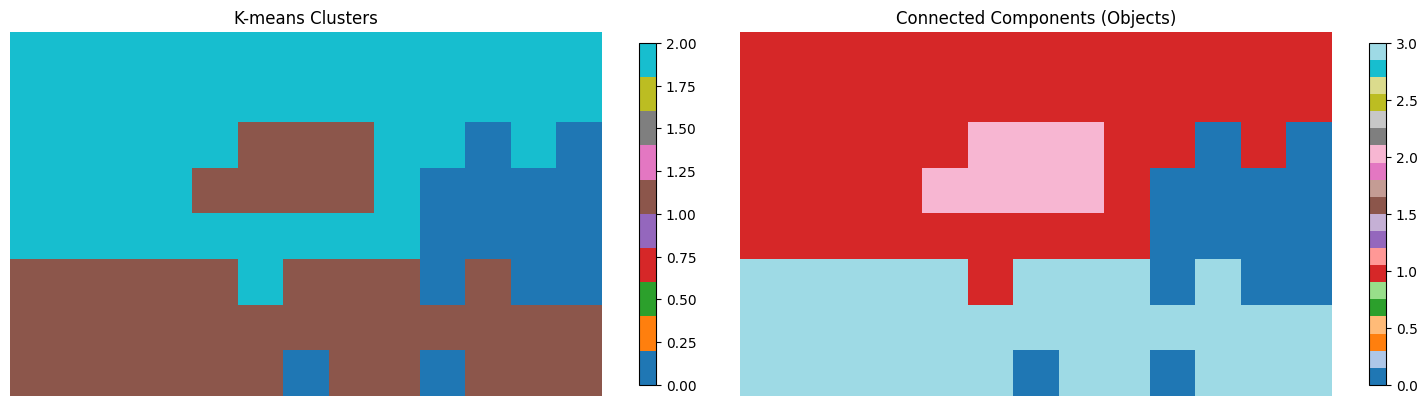

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [198, 212, 225],
        [198, 212, 225]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [198, 212, 225],
        [198, 212, 225]],

       [[255,   0,   0],
        [255,   0,   0],
        [ 80, 134, 208],
        ...,
        [255,   0,   0],
        [198, 212, 225],
        [198, 212, 225]],

       ...,

       [[ 89, 147, 169],
        [ 89, 147, 169],
        [ 92, 150, 172],
        ...,
        [ 82, 153, 173],
        [ 77, 148, 168],
        [ 76, 147, 167]],

       [[ 88, 146, 168],
        [ 89, 147, 169],
        [ 91, 149, 171],
        ...,
        [ 77, 148, 166],
        [ 72, 143, 161],
        [ 69, 140, 158]],

       [[ 93, 151, 173],
        [ 96, 154, 176],
        [100, 158, 180],
        ...,
        [ 78, 149, 167],
        [ 74, 145, 163],
        [ 70, 141, 159]]

In [22]:
### START CODE HERE ###

tile_size = 128
stride = 64
hog_extractor = HOGSubimageExtractor(image, tile_size, stride)
kmeans_cluster = KMeansCluster(hog_extractor)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image,bboxes)



### END CODE HERE ###

---

## **Question** 
1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?

2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?

3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?

4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering?

5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)? 
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>

![q5.jpg](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/q5.jpg?raw=true)


## 1. How do the parameters of Gaussian blur affect image processing in k-means clustering?
Kernel Size and Standard Deviation Effects:

- Larger kernel size (e.g., 41x41): Removes more fine details and noise, creating smoother HOG features that group similar regions together. This leads to more stable clustering but may lose important object boundaries.
- Smaller kernel size (e.g., 5x5): Preserves more edge details and texture information, resulting in more detailed HOG features. This can improve object detection but may introduce noise that affects clustering quality.
- Standard deviation: Controls the blur intensity. Higher values create stronger smoothing effects, while lower values preserve more detail.
##### Impact on K-means:

- Heavy blur → More homogeneous features → Better separation between large regions (foreground/background)
- Light blur → More detailed features → Better detection of small objects but more noise in clustering

## 2. How do cells per block and pixels per cell configurations influence object detection effectiveness?
##### Cells per Block:
- Smaller blocks (2x2): More localized features, sensitive to local changes
- Larger blocks (3x3): More context-aware features, better normalization across larger regions

##### Pixels per Cell:
- Smaller values (6x6): Capture finer details and textures, better for detecting small objects or intricate patterns
- Larger values (8x8): Focus on broader structural patterns, more robust to noise but may miss fine details

##### For dolphin detection:

- Medium values (6x6 pixels per cell, 3x3 cells per block) work best as they balance detail capture with noise robustness for organic shapes

## 3. What differences can be observed when using smaller vs larger sub-images (tiles)?
##### Smaller Tiles (64x64):
- Advantages: Higher spatial resolution, can detect smaller objects, more precise localization
- Disadvantages: More susceptible to noise, may fragment large objects, creates many small bounding boxes
- Result: Many detailed detections but potentially fragmented object representation

##### Larger Tiles (128x128+):
- Advantages: Better context capture, more stable features, fewer fragmented detections
- Disadvantages: Lower spatial resolution, may miss small objects, less precise boundaries
- Result: Fewer but more coherent bounding boxes, better for large object detection
- Optimal Choice: Medium tile sizes (100-128 pixels) often provide the best balance for most objects.

## 4. What is the impact if the labeling step is skipped before applying k-means clustering?
Without Connected Component Labeling (measure.label()):

- Problem: K-means only assigns cluster IDs to each tile individually
- Result: Spatially disconnected tiles with the same cluster ID would be treated as the same object
- Consequence: Single large bounding box encompassing all tiles of the same cluster, regardless of spatial proximity
##### With Connected Component Labeling:

- Benefit: Groups only spatially adjacent tiles with the same cluster ID
- Result: Separate bounding boxes for each spatially connected region
- Advantage: Proper object segmentation and multiple object detection
##### Example: Without labeling, all "water" tiles would create one huge bounding box. With labeling, separate water regions get individual bounding boxes.

## 5. How does the number of clusters (K) affect image clustering results?

